# Logistic Regression & LSTM Performances Comparison
#### 1. Standard Undersampling
#### 2. Standard Oversampling
#### 3. SMOTE
#### 4. ADASYN
#### 5. OSTSC

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import itertools
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from keras.utils import np_utils
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler

## load data
##### This is High Frequency Trading data, random selected 30000 time sequences from real world data for experiments.

First column is the label, the rest 10 columns are features.

In [154]:
df = pd.read_csv('/home/lwei/Documents/Train 0.8toy 10column (30000).csv')
df = df.drop(df.columns[[0]], axis=1).drop('index',1)

Find the distribusion of classes.

In [155]:
df['label'].value_counts()

 0    28800
-1      600
 1      600
Name: label, dtype: int64

Split training and testing data.

In [156]:
train = df[1:int(0.6*df.shape[0])]
test = df[int(0.6*df.shape[0]):df.shape[0]]

In [157]:
test['label'].value_counts()

 0    11454
 1      284
-1      262
Name: label, dtype: int64

In [158]:
x_test = test.drop('label',1)
y_test = test['label']

## Functions
#### This function prepare data format for LSTM

In [20]:
def generate(x_train,y_train,x_test,y_test, n_step = 10):
    
    sample_data = x_train.as_matrix()
    sample_label = y_train.as_matrix()
    test_data = x_test.as_matrix()
    test_label = y_test.as_matrix()

    sample_label[sample_label == 1] = 2
    test_label[test_label == 1] = 2
    sample_label[sample_label == 0] = 1
    test_label[test_label == 0] = 1
    sample_label[sample_label == -1] = 0
    test_label[test_label == -1] = 0

    sample_label = np_utils.to_categorical(sample_label)
    test_label = np_utils.to_categorical(test_label)

    X_data = []
    y_data = []
    X_test = []
    y_test = []
    
   
    for i in range(0,sample_data.shape[0],1):
        X_data.append(np.asarray([sample_data[i, :]]).T)
        y_data.append(sample_label[i])
    
    for i in range(0,test_data.shape[0],1):
        X_test.append(np.asarray([test_data[i, :]]).T)
        y_test.append(test_label[i])
        

    X_train = np.array(X_data)
    y_train = np.array(y_data)
    X_test = np.array(X_test)
    y_test = np.array(y_test)


    return X_train, y_train, X_test, y_test


#### This function plot confusion matrix

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 5)
        #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color=#"white" if cm[i, j] > thresh else 
                 "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Logistic Regression

### model

In [48]:
logreg = linear_model.LogisticRegression()

#### 1. standard undersampling
##### undersampling

In [49]:
minNumber = min(sum(train.label == 1), sum(train.label == -1))

indices = train[train.label == 0].index
zero_indices = np.random.choice(indices, minNumber, replace=False)
sample_zero = train.loc[zero_indices]

positive1 = train[train.label == 1].index
posi1_indices = np.random.choice(positive1, minNumber, replace=False)
sample_posi1 = train.loc[posi1_indices]

positive2 = train[train.label == -1].index
posi2_indices = np.random.choice(positive2, minNumber, replace=False)
sample_posi2 = train.loc[posi2_indices]

frames = [sample_posi1, sample_posi2, sample_zero]
result = pd.concat(frames)
undersample = result.sort_index(axis=0)

x_train=undersample.drop('label',1)
y_train=undersample['label']

##### check balance

In [50]:
y_train.value_counts()

 1    316
 0    316
-1    316
Name: label, dtype: int64

##### fit, predict, evaluate (on F1 value)

In [51]:
logreg.fit(x_train, y_train)
prediction = logreg.predict(x_test)
matrix = confusion_matrix(y_test, prediction)
f1_score(y_test, prediction, average=None)

array([ 0.08243798,  0.29912889,  0.08509841])

##### confusion matrix

Confusion matrix, without normalization
[[ 211   32   19]
 [4623 2026 4805]
 [  23   34  227]]
Normalized confusion matrix
[[ 0.80534  0.12214  0.07252]
 [ 0.40361  0.17688  0.4195 ]
 [ 0.08099  0.11972  0.7993 ]]


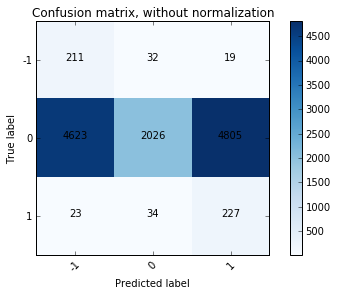

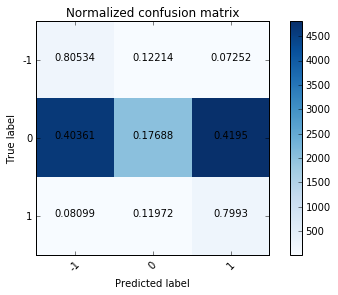

In [52]:
plt.figure()
plot_confusion_matrix(matrix,[-1, 0, 1], 
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(matrix, [-1, 0, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

#### 2. standard oversampling
##### oversampling

In [53]:
x_train_over = train.drop('label',1)
y_train_over = train['label']
X_train_over = np.array(x_train_over)
Y_train_over = np.array(y_train_over)

ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_sample( X_train_over, Y_train_over)

random_x = pd.DataFrame(X_resampled)
random_y = pd.DataFrame(y_resampled)


##### check balance

In [54]:
random_y.columns = ['label']
random_y['label'].value_counts()

-1    17345
 1    17345
 0    17345
Name: label, dtype: int64

##### fit, predict, evaluate (on F1 value)

In [55]:
random_y = random_y.values.ravel()
logreg.fit(random_x, random_y)
prediction = logreg.predict(x_test)
matrix = confusion_matrix(y_test, prediction)
f1_score(y_test, prediction, average=None)

array([ 0.08260524,  0.31384886,  0.08611898])

##### confusion matrix

Confusion matrix, without normalization
[[ 208   35   19]
 [4545 2145 4764]
 [  21   35  228]]
Normalized confusion matrix
[[ 0.79389  0.13359  0.07252]
 [ 0.3968   0.18727  0.41592]
 [ 0.07394  0.12324  0.80282]]


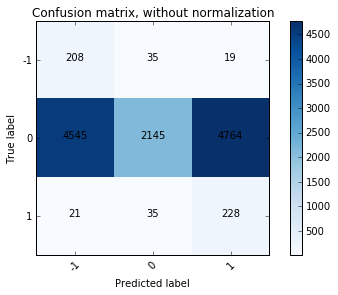

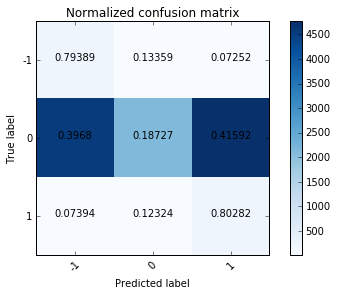

In [56]:
plt.figure()
plot_confusion_matrix(matrix, [-1, 0, 1], 
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(matrix, [-1, 0, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

#### 3. SMOTE
##### oversampling

In [57]:
sm = SMOTE()

negative = train[train.label == 0]
positive1 = train[train.label == 1]
positive2 = train[train.label == -1]
over1 = pd.concat([positive1, negative])
over2 = pd.concat([positive2, negative])

x_over1 = over1.drop('label',1)
y_over1 = over1['label']
x_over2 = over2.drop('label',1)
y_over2 = over2['label']

x_res1, y_res1 = sm.fit_sample(x_over1, y_over1)
x_res2, y_res2 = sm.fit_sample(x_over2, y_over2)

x_res1 = pd.DataFrame(x_res1)
x_res1.columns = ['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10']
x_res1['label'] = y_res1
x_res1 = x_res1[x_res1.label == 1]
y_res1 = x_res1['label']
x_res1 = x_res1.drop('label',1)

X_res = np.concatenate((x_res1, x_res2))
y_res = np.concatenate((y_res1, y_res2))

smote_x = pd.DataFrame(X_res)
smote_y = pd.DataFrame(y_res)


##### check balance

In [58]:
smote_y[0].value_counts()

-1    17345
 1    17345
 0    17345
Name: 0, dtype: int64

##### fit, predict, evaluate (on F1 value

In [59]:
smote_y = smote_y.values.ravel()
logreg.fit(smote_x, smote_y)
prediction = logreg.predict(x_test)
matrix = confusion_matrix(y_test, prediction)
f1_score(y_test, prediction, average=None)

array([ 0.08253589,  0.32177713,  0.08679102])

##### confusion matrix

Confusion matrix, without normalization
[[ 207   35   20]
 [4523 2209 4722]
 [  24   32  228]]
Normalized confusion matrix
[[ 0.79008  0.13359  0.07634]
 [ 0.39488  0.19286  0.41226]
 [ 0.08451  0.11268  0.80282]]


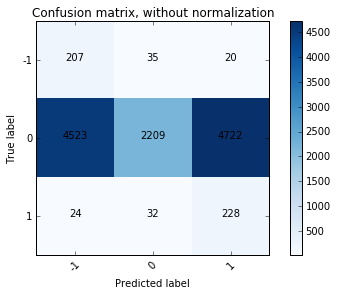

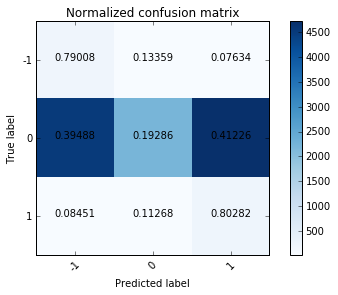

In [60]:
plt.figure()
plot_confusion_matrix(matrix, [-1, 0, 1], 
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(matrix, [-1, 0, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

#### 4. ADASYN
##### oversampling

In [61]:
ada = ADASYN()
x_ada1, y_ada1 = ada.fit_sample(x_over1, y_over1)
x_ada2, y_ada2 = ada.fit_sample(x_over2, y_over2)
x_ada1 = pd.DataFrame(x_ada1)
x_ada1.columns = ['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'feature10']
x_ada1['label'] = y_ada1
x_ada1 = x_ada1[x_ada1.label == 1]
y_ada1 = x_ada1['label']
x_ada1 = x_ada1.drop('label',1)

X_ada = np.concatenate((x_ada1, x_ada2))
y_ada = np.concatenate((y_ada1, y_ada2))

ada_x = pd.DataFrame(X_ada)
ada_y = pd.DataFrame(y_ada)

##### check balance

In [62]:
ada_y.columns = ['label']
ada_y['label'].value_counts()

-1    17347
 0    17345
 1    17327
Name: label, dtype: int64

##### fit, predict, evaluate (on F1 value)

In [63]:
ada_y = ada_y.values.ravel()
logreg.fit(ada_x, ada_y)
prediction = logreg.predict(x_test)
matrix = confusion_matrix(y_test, prediction)
f1_score(y_test, prediction, average=None)

array([ 0.07490478,  0.3616736 ,  0.07292688])

##### confusion matrix

Confusion matrix, without normalization
[[ 177   69   16]
 [4276 2563 4615]
 [  11   87  186]]
Normalized confusion matrix
[[ 0.67557  0.26336  0.06107]
 [ 0.37332  0.22376  0.40292]
 [ 0.03873  0.30634  0.65493]]


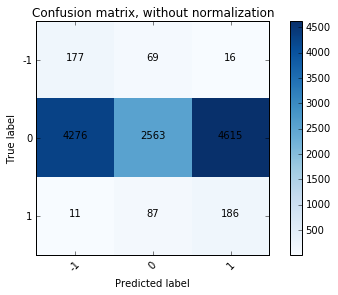

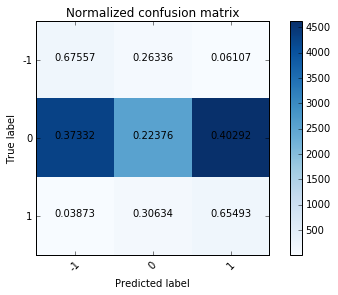

In [64]:
plt.figure()
plot_confusion_matrix(matrix, [-1, 0, 1], 
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(matrix, [-1, 0, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

#### 5. OSTSC
##### Oversampling

In [70]:
x_ostsc = pd.read_csv('/home/lwei/Documents/OSTSC_x.csv')
y_ostsc = pd.read_csv('/home/lwei/Documents/OSTSC_y.csv')

x_ostsc = x_ostsc.drop(x_ostsc.columns[[0]], axis=1)
y_ostsc = y_ostsc.drop(y_ostsc.columns[[0]], axis=1)

##### check balance

In [72]:
y_ostsc.columns = ['label']
y_ostsc['label'].value_counts()

 1    17684
-1    17662
 0    17346
Name: label, dtype: int64

##### fit, predict, evaluate (on F1 value)

In [73]:
y_ostsc = y_ostsc.values.ravel()
logreg.fit(x_ostsc, y_ostsc)
prediction = logreg.predict(x_test)
matrix = confusion_matrix(y_test, prediction)
f1_score(y_test, prediction, average=None)

array([ 0.08476287,  0.35772821,  0.08938547])

##### confusion matrix

Confusion matrix, without normalization
[[ 210   32   20]
 [4460 2510 4484]
 [  23   37  224]]
Normalized confusion matrix
[[ 0.80153  0.12214  0.07634]
 [ 0.38938  0.21914  0.39148]
 [ 0.08099  0.13028  0.78873]]


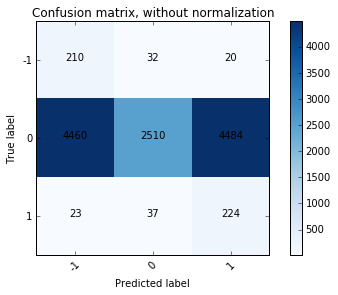

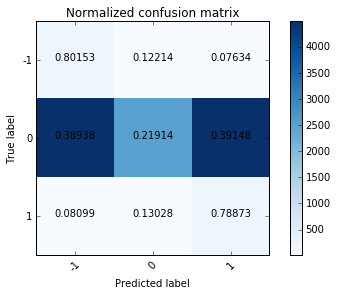

In [74]:
plt.figure()
plot_confusion_matrix(matrix, [-1, 0, 1], 
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(matrix, [-1, 0, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## LSTM

#### 1. standard undersampling
##### change data format & check dimension

In [75]:
xtrain,ytrain,xtest,ytest=generate(x_train,y_train,x_test,y_test)
print (x_train.shape,y_train.shape,x_test.shape,y_test.shape)
print (xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)

(948, 10) (948,) (12000, 10) (12000,)
(948, 10, 1) (948, 3) (12000, 10, 1) (12000, 3)


##### training

In [77]:
model = Sequential()
model.add(LSTM(10, stateful=False, input_shape=(xtrain.shape[1], xtrain.shape[-1])))
model.add(Dense(ytrain.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(xtrain, ytrain, nb_epoch=20, verbose=1,validation_split=0.02)

/home/lwei/.local/lib/python3.5/site-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 929 samples, validate on 19 samples
Epoch 1/20
929/929 [==============================] - 0s - loss: 1.0836 - acc: 0.4995 - val_loss: 1.0846 - val_acc: 0.2632
Epoch 2/20
929/929 [==============================] - 0s - loss: 1.0587 - acc: 0.4822 - val_loss: 1.0711 - val_acc: 0.3158
Epoch 3/20
929/929 [==============================] - 0s - loss: 1.0266 - acc: 0.5447 - val_loss: 1.0506 - val_acc: 0.3684
Epoch 4/20
929/929 [==============================] - 0s - loss: 0.9811 - acc: 0.5608 - val_loss: 1.0241 - val_acc: 0.3684
Epoch 5/20
929/929 [==============================] - 0s - loss: 0.9271 - acc: 0.5673 - val_loss: 0.9705 - val_acc: 0.4211
Epoch 6/20
929/929 [==============================] - 0s - loss: 0.8962 - acc: 0.5737 - val_loss: 0.9555 - val_acc: 0.4737
Epoch 7/20
929/929 [==============================] - 0s - loss: 0.8808 - acc: 0.5834 - val_loss: 0.9342 - val_acc: 0.4737
Epoch 8/20
929/929 [==============================] - 0s - loss: 0.8742 - acc: 0.6006 - val_lo

##### predict, evaluate (on F1 value)

In [78]:
prediction = model.predict(xtest)
true_values = np.argmax(ytest, axis=1)
pred = np.argmax(prediction, axis = 1)
matrix = confusion_matrix(true_values, pred)
f1_score(true_values, pred, average=None)

array([ 0.11931635,  0.61565238,  0.10431909])

##### confusion matrix

Confusion matrix, without normalization
[[ 185   44   33]
 [2626 5129 3699]
 [  28   35  221]]
Normalized confusion matrix
[[ 0.70611  0.16794  0.12595]
 [ 0.22926  0.44779  0.32294]
 [ 0.09859  0.12324  0.77817]]


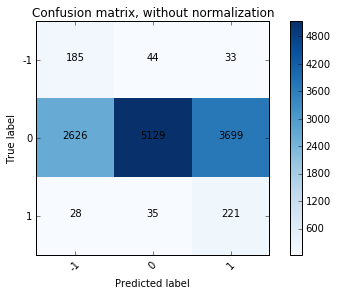

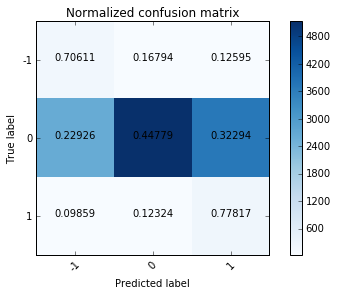

In [79]:
plt.figure()
plot_confusion_matrix(matrix,[-1, 0, 1], 
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(matrix, [-1, 0, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

#### 2. standard oversampling
##### change data format & check dimension

In [115]:
random_y = pd.DataFrame(y_resampled)
xtrain_random,ytrain_random,xtest_random,ytest_random=generate(random_x,random_y,x_test,y_test)
print (random_x.shape,random_y.shape,x_test.shape,y_test.shape)
print (xtrain_random.shape,ytrain_random.shape,xtest_random.shape,ytest_random.shape)

(52035, 10) (52035, 1) (12000, 10) (12000,)
(52035, 10, 1) (52035, 3) (12000, 10, 1) (12000, 3)


##### training

In [84]:
model_random = Sequential()
model_random.add(LSTM(10, stateful=False, input_shape=(xtrain_random.shape[1], xtrain_random.shape[-1])))
model_random.add(Dense(ytrain_random.shape[1], activation='softmax'))
model_random.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_random.fit(xtrain_random, ytrain_random, nb_epoch=20, verbose=1,validation_split=0.02)

/home/lwei/.local/lib/python3.5/site-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 50994 samples, validate on 1041 samples
Epoch 1/20
50994/50994 [==============================] - 32s - loss: 0.7879 - acc: 0.6499 - val_loss: 0.6343 - val_acc: 0.7752
Epoch 2/20
50994/50994 [==============================] - 33s - loss: 0.6851 - acc: 0.7158 - val_loss: 0.6088 - val_acc: 0.7570
Epoch 3/20
50994/50994 [==============================] - 32s - loss: 0.6450 - acc: 0.7376 - val_loss: 0.5745 - val_acc: 0.7675
Epoch 4/20
50994/50994 [==============================] - 33s - loss: 0.6247 - acc: 0.7449 - val_loss: 0.5555 - val_acc: 0.8012
Epoch 5/20
50994/50994 [==============================] - 33s - loss: 0.6109 - acc: 0.7520 - val_loss: 0.5376 - val_acc: 0.7867
Epoch 6/20
50994/50994 [==============================] - 33s - loss: 0.5957 - acc: 0.7580 - val_loss: 0.5420 - val_acc: 0.7800
Epoch 7/20
50994/50994 [==============================] - 34s - loss: 0.5813 - acc: 0.7618 - val_loss: 0.5268 - val_acc: 0.7560
Epoch 8/20
50994/50994 [==============================]

##### predict, evaluate (on F1 values)

In [116]:
prediction_random = model_random.predict(xtest_random)
true_values_random = np.argmax(ytest_random, axis=1)
pred_random = np.argmax(prediction_random, axis = 1)
confusion_matrix_random = confusion_matrix(true_values_random, pred_random)
f1_score(true_values_random, pred_random, average=None)

array([ 0.21249385,  0.849337  ,  0.2320888 ])

##### confusion matrix

Confusion matrix, without normalization
[[ 216   20   26]
 [1525 8487 1442]
 [  30   24  230]]
Normalized confusion matrix
[[ 0.82443  0.07634  0.09924]
 [ 0.13314  0.74096  0.12589]
 [ 0.10563  0.08451  0.80986]]


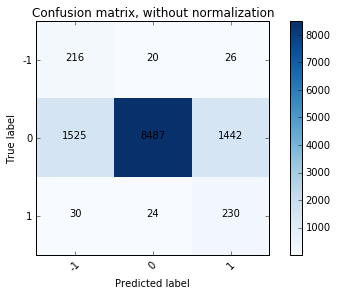

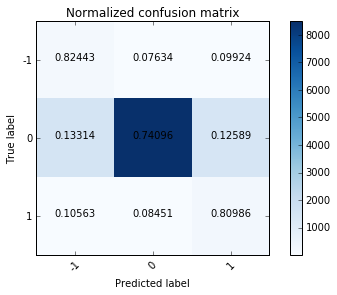

In [118]:
plt.figure()
plot_confusion_matrix(confusion_matrix_random, [-1, 0, 1], 
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(confusion_matrix_random, [-1, 0, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

#### 3. SMOTE
##### change data format & check dimension

In [129]:
smote_y = pd.DataFrame(y_res)
xtrain_smote,ytrain_smote,xtest_smote,ytest_smote=generate(smote_x,smote_y,x_test,y_test)
print (smote_x.shape,smote_y.shape,x_test.shape,y_test.shape)
print (xtrain_smote.shape,ytrain_smote.shape,xtest_smote.shape,ytest_smote.shape)

(52035, 10) (52035, 1) (12000, 10) (12000,)
(52035, 10, 1) (52035, 3) (12000, 10, 1) (12000, 3)


##### training

In [121]:
model_smote = Sequential()
model_smote.add(LSTM(10, stateful=False, input_shape=(xtrain_smote.shape[1], xtrain_smote.shape[-1])))
model_smote.add(Dense(ytrain_smote.shape[1], activation='softmax'))
model_smote.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_smote.fit(xtrain_smote, ytrain_smote, nb_epoch=20, verbose=1,validation_split=0.02)

/home/lwei/.local/lib/python3.5/site-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 50994 samples, validate on 1041 samples
Epoch 1/20
50994/50994 [==============================] - 33s - loss: 0.8041 - acc: 0.6477 - val_loss: 0.6911 - val_acc: 0.7541
Epoch 2/20
50994/50994 [==============================] - 34s - loss: 0.6893 - acc: 0.7150 - val_loss: 0.6271 - val_acc: 0.7541
Epoch 3/20
50994/50994 [==============================] - 32s - loss: 0.6548 - acc: 0.7212 - val_loss: 0.5656 - val_acc: 0.7771
Epoch 4/20
50994/50994 [==============================] - 32s - loss: 0.6398 - acc: 0.7254 - val_loss: 0.5823 - val_acc: 0.7752
Epoch 5/20
50994/50994 [==============================] - 33s - loss: 0.6262 - acc: 0.7332 - val_loss: 0.5585 - val_acc: 0.7915
Epoch 6/20
50994/50994 [==============================] - 32s - loss: 0.6146 - acc: 0.7393 - val_loss: 0.5317 - val_acc: 0.8031
Epoch 7/20
50994/50994 [==============================] - 32s - loss: 0.6061 - acc: 0.7422 - val_loss: 0.5145 - val_acc: 0.7733
Epoch 8/20
50994/50994 [==============================]

##### predict, evaluate (on F1 values)

In [130]:
prediction_smote = model_smote.predict(xtest_smote)
true_values_smote = np.argmax(ytest_smote, axis=1)
pred_smote = np.argmax(prediction_smote, axis = 1)
confusion_matrix_smote = confusion_matrix(true_values_smote, pred_smote)
f1_score(true_values_smote, pred_smote, average=None)

array([ 0.17276014,  0.81164667,  0.21977011])

##### confusion matrix

Confusion matrix, without normalization
[[ 215   18   29]
 [1984 7847 1623]
 [  28   17  239]]
Normalized confusion matrix
[[ 0.82061  0.0687   0.11069]
 [ 0.17321  0.68509  0.1417 ]
 [ 0.09859  0.05986  0.84155]]


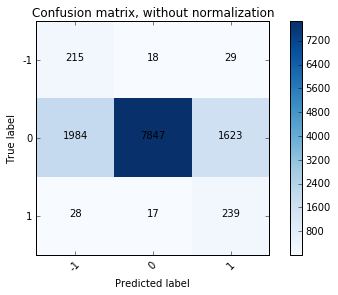

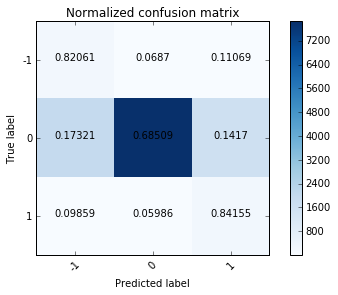

In [131]:
plt.figure()
plot_confusion_matrix(confusion_matrix_smote, [-1, 0, 1], 
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(confusion_matrix_smote, [-1, 0, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

#### 4. ADASYN
##### change data format & check dimension

In [143]:
ada_y = pd.DataFrame(y_ada)
xtrain_ada,ytrain_ada,xtest_ada,ytest_ada=generate(ada_x,ada_y,x_test,y_test)
print (ada_x.shape,ada_y.shape,x_test.shape,y_test.shape)
print (xtrain_ada.shape,ytrain_ada.shape,xtest_ada.shape,ytest_ada.shape)

(52019, 10) (52019, 1) (12000, 10) (12000,)
(52019, 10, 1) (52019, 3) (12000, 10, 1) (12000, 3)


##### training

In [134]:
model_ada = Sequential()
model_ada.add(LSTM(10, stateful=False, input_shape=(xtrain_ada.shape[1], xtrain_ada.shape[-1])))
model_ada.add(Dense(ytrain_ada.shape[1], activation='softmax'))
model_ada.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ada.fit(xtrain_ada, ytrain_ada, nb_epoch=20, verbose=1, validation_split=0.02)

/home/lwei/.local/lib/python3.5/site-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 50978 samples, validate on 1041 samples
Epoch 1/20
50978/50978 [==============================] - 32s - loss: 0.8049 - acc: 0.6384 - val_loss: 0.4385 - val_acc: 0.8703
Epoch 2/20
50978/50978 [==============================] - 31s - loss: 0.7036 - acc: 0.7081 - val_loss: 0.4985 - val_acc: 0.8300
Epoch 3/20
50978/50978 [==============================] - 32s - loss: 0.6700 - acc: 0.7248 - val_loss: 0.5495 - val_acc: 0.8309
Epoch 4/20
50978/50978 [==============================] - 32s - loss: 0.6441 - acc: 0.7306 - val_loss: 0.4919 - val_acc: 0.8271
Epoch 5/20
50978/50978 [==============================] - 33s - loss: 0.6301 - acc: 0.7350 - val_loss: 0.4901 - val_acc: 0.7454
Epoch 6/20
50978/50978 [==============================] - 35s - loss: 0.6176 - acc: 0.7389 - val_loss: 0.4899 - val_acc: 0.7397
Epoch 7/20
50978/50978 [==============================] - 31s - loss: 0.6070 - acc: 0.7417 - val_loss: 0.5804 - val_acc: 0.7329
Epoch 8/20
50978/50978 [==============================]

##### predict, evaluate (on F1 values)

In [144]:
prediction_ada = model_ada.predict(xtest_ada)
true_values_ada = np.argmax(ytest_ada, axis=1)
pred_ada = np.argmax(prediction_ada, axis = 1)
confusion_matrix_ada = confusion_matrix(true_values_ada, pred_ada)
f1_score(true_values_ada, pred_ada, average=None)

array([ 0.14061903,  0.76567196,  0.173755  ])

##### confusion matrix

Confusion matrix, without normalization
[[ 184   30   48]
 [2141 7133 2180]
 [  30   15  239]]
Normalized confusion matrix
[[ 0.70229  0.1145   0.18321]
 [ 0.18692  0.62275  0.19033]
 [ 0.10563  0.05282  0.84155]]


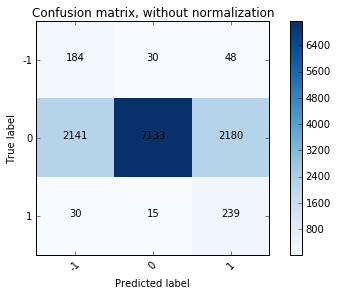

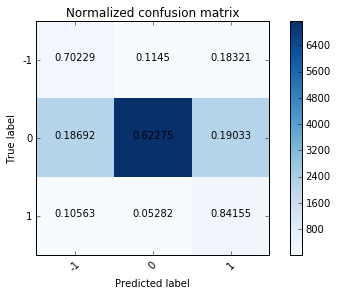

In [145]:
plt.figure()
plot_confusion_matrix(confusion_matrix_ada, [-1, 0, 1], 
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(confusion_matrix_ada, [-1, 0, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.show()

#### 5. OSTSC
##### change data format & check dimension

In [159]:
xtraino,ytraino,xtesto,ytesto=generate(x_ostsc,pd.DataFrame(y_ostsc),x_test,y_test)
print (x_ostsc.shape,y_ostsc.shape,x_test.shape,y_test.shape)
print (xtraino.shape,ytraino.shape,xtesto.shape,ytesto.shape)

(52692, 10) (52692,) (12000, 10) (12000,)
(52692, 10, 1) (52692, 3) (12000, 10, 1) (12000, 3)


##### training

In [152]:
modelo = Sequential()
modelo.add(LSTM(10, stateful=False, input_shape=(xtraino.shape[1], xtraino.shape[-1])))
modelo.add(Dense(ytraino.shape[1], activation='softmax'))
modelo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
modelo.fit(xtraino, ytraino, nb_epoch=20, verbose=1,validation_split=0.02)

/home/lwei/.local/lib/python3.5/site-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 51638 samples, validate on 1054 samples
Epoch 1/20
51638/51638 [==============================] - 35s - loss: 0.7374 - acc: 0.6707 - val_loss: 0.8022 - val_acc: 0.5579
Epoch 2/20
51638/51638 [==============================] - 32s - loss: 0.5988 - acc: 0.7446 - val_loss: 0.5412 - val_acc: 0.7372
Epoch 3/20
51638/51638 [==============================] - 31s - loss: 0.4948 - acc: 0.8011 - val_loss: 0.4932 - val_acc: 0.7476
Epoch 4/20
51638/51638 [==============================] - 31s - loss: 0.4524 - acc: 0.8233 - val_loss: 0.3127 - val_acc: 0.9383
Epoch 5/20
51638/51638 [==============================] - 30s - loss: 0.4292 - acc: 0.8335 - val_loss: 0.3799 - val_acc: 0.8700
Epoch 6/20
51638/51638 [==============================] - 30s - loss: 0.4110 - acc: 0.8405 - val_loss: 0.4057 - val_acc: 0.8643
Epoch 7/20
51638/51638 [==============================] - 30s - loss: 0.3948 - acc: 0.8491 - val_loss: 0.3556 - val_acc: 0.8947
Epoch 8/20
51638/51638 [==============================]

##### predict, evaluate (on F1 values)

In [167]:
predictiono = modelo.predict(xtesto)
true_valueso = np.argmax(ytesto, axis=1)
predo = np.argmax(predictiono, axis = 1)
confusion_matrix = confusion_matrix(true_valueso, predo)
f1_score(true_valueso, predo, average=None)

array([ 0.31067961,  0.93840679,  0.2961039 ])

##### confusion matrix

Confusion matrix, without normalization
[[  144    93    25]
 [  495 10284   675]
 [   26    87   171]]
Normalized confusion matrix
[[ 0.54962  0.35496  0.09542]
 [ 0.04322  0.89785  0.05893]
 [ 0.09155  0.30634  0.60211]]


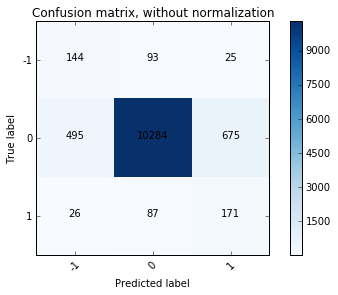

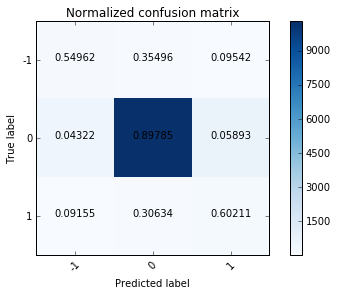

In [168]:
plt.figure()
plot_confusion_matrix(confusion_matrix, [-1, 0, 1], 
                      title='Confusion matrix, without normalization')
plt.figure()
plot_confusion_matrix(confusion_matrix, [-1, 0, 1], normalize=True,
                      title='Normalized confusion matrix')
plt.show()